In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
import copy
import datetime
import glob
import itertools
import os
import random
from bisect import bisect_left
from math import hypot
from typing import List, Tuple, Union
import sys
from matplotlib.pyplot import xlabel, xscale
import numpy as np
import pandas as pd
import pickle5 as pickle
import zipfile

import sys
sys.path.append('../src/')
sys.path.append('../src/old/')
import names
import df_utils
import bootstrap
# import generate_ws_dataframe
import parameters
import interpolate
import training
from utils_ws import *
import stats

In [165]:
data_dir = 'data/skPleiades_solver=dneal_n=100'
df = df_utils.read_exp_raw(data_dir)
display(df)

,instance,schedule,sweep,Tcfactor,Thfactor,boots,Key=MinEnergy,ConfInt=lower_Key=MinEnergy,ConfInt=upper_Key=MinEnergy,Key=PerfRatio,...,Key=RTT,ConfInt=lower_Key=RTT,ConfInt=upper_Key=RTT,Key=MeanTime,ConfInt=lower_Key=MeanTime,ConfInt=upper_Key=MeanTime,Key=InvPerfRatio,ConfInt=lower_Key=InvPerfRatio,ConfInt=upper_Key=InvPerfRatio,inst
0,5,geometric,1,0.0,-0.875,1,-49.047289,-69.738819,-27.105193,0.212525,...,inf,inf,inf,309.0,309.0,309.0,7.874752e-01,6.994441e-01,8.808268e-01,5
1,5,geometric,1,0.0,-0.875,1,-48.211694,-67.719387,-27.005434,0.208970,...,inf,inf,inf,309.0,309.0,309.0,7.910302e-01,7.080357e-01,8.812512e-01,5
2,5,geometric,1,0.0,-0.875,2,-62.463962,-80.712636,-46.292989,0.269605,...,inf,inf,inf,309.0,309.0,309.0,7.303946e-01,6.527565e-01,7.991933e-01,5
3,5,geometric,1,0.0,-0.875,3,-68.320808,-83.903391,-52.663025,0.294523,...,inf,inf,inf,309.0,309.0,309.0,7.054770e-01,6.391816e-01,7.720923e-01,5
4,5,geometric,1,0.0,-0.875,5,-74.657448,-88.882087,-60.296653,0.321482,...,inf,inf,inf,309.0,309.0,309.0,6.785180e-01,6.180000e-01,7.396153e-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507261,8,geometric,250,0.0,-1.750,200,-229.485278,-229.485278,-229.485278,1.000000,...,23.739605,18.312887,29.327155,531.0,531.0,531.0,1.000001e-10,1.000000e-10,1.000000e-10,8
10507262,8,geometric,250,0.0,-1.750,300,-229.485278,-229.485278,-229.485278,1.000000,...,23.188366,19.129163,26.974380,531.0,531.0,531.0,1.000001e-10,1.000000e-10,1.000000e-10,8
10507263,8,geometric,250,0.0,-1.750,500,-229.485278,-229.485278,-229.485278,1.000000,...,22.815655,19.475013,25.928616,531.0,531.0,531.0,1.000001e-10,1.000000e-10,1.000000e-10,8
10507264,8,geometric,250,0.0,-1.750,700,-229.485278,-229.485278,-229.485278,1.000000,...,22.825791,20.149375,25.503757,531.0,531.0,531.0,1.000001e-10,1.000000e-10,1.000000e-10,8


In [28]:
sm = stats.Percentile(50, 10)
base = df['Key=PerfRatio']
lower = df['ConfInt=lower_Key=PerfRatio']
upper = df['ConfInt=upper_Key=PerfRatio']
ci = sm.ConfInts(base, lower, upper)

sm = stats.Median()
ci_med = sm.ConfInts(base, lower, upper)

print(ci)
print(ci_med)

[0.         0.02973695 0.0176722  ... 0.00352089 0.01554842 0.        ]
[ 0.          0.0028649  -0.03259168 ... -0.00168312 -0.01470491
  0.        ]
------
[0.02241446 0.         0.06940636 ... 0.         0.02084615 0.00554368]
[ 0.01439663  0.          0.13670759 ...  0.         -0.01624884
 -0.00747118]
------
[0.00052037 0.         0.0645381  ... 0.         0.0327289  0.01094304]
[-2.01116043e-05  0.00000000e+00  1.06874677e-01 ...  0.00000000e+00
  2.38408842e-02 -1.37235812e-02]
------
[0.03446169 0.0010196  0.         ... 0.0151275  0.01733694 0.00827418]
[ 0.03175102 -0.00138974  0.         ... -0.00942836  0.00738823
  0.00160364]
------
[0.00857695 0.0262198  0.01039764 ... 0.00221403 0.         0.01459871]
[-0.00974701 -0.01403983 -0.009515   ...  0.000322    0.
  0.01205141]
------
[0.01391853 0.00490348 0.         ... 0.00079685 0.01650296 0.05117393]
[ 0.00050281 -0.00313698  0.         ...  0.00025238 -0.02016479
 -0.00956861]
------
[0.00701675 0.00473818 0.02621216 ..

In [27]:
display(df[lower == upper].loc[:, ['Key=PerfRatio', 'ConfInt=lower_Key=PerfRatio', 'ConfInt=upper_Key=PerfRatio']])

,Key=PerfRatio,ConfInt=lower_Key=PerfRatio,ConfInt=upper_Key=PerfRatio
1804,0.993118,0.995551,0.995551
1823,0.982222,0.982620,0.982620
1885,0.999304,1.000000,1.000000
1886,0.999830,1.000000,1.000000
1887,0.999934,1.000000,1.000000
...,...,...,...
10507261,1.000000,1.000000,1.000000
10507262,1.000000,1.000000,1.000000
10507263,1.000000,1.000000,1.000000
10507264,1.000000,1.000000,1.000000


In [81]:
myclass = bootstrap.BSParams_iter()
bsparams_iter = myclass(names.param2filename({'Key': 'MinEnergy'}, ''), 'sweep', 2)

group_on = ['instance']
test_df = bootstrap.Bootstrap(df, group_on, bsparams_iter)
display(test_df)

,instance,Key=Response,ConfInt=lower_Key=Response,ConfInt=upper_Key=Response,Key=PerfRatio,ConfInt=lower_Key=PerfRatio,ConfInt=upper_Key=PerfRatio,Key=SuccProb,ConfInt=lower_Key=SuccProb,ConfInt=upper_Key=SuccProb,Key=RTT,ConfInt=lower_Key=RTT,ConfInt=upper_Key=RTT,Key=MeanTime,ConfInt=lower_Key=MeanTime,ConfInt=upper_Key=MeanTime,Key=InvPerfRatio,ConfInt=lower_Key=InvPerfRatio,ConfInt=upper_Key=InvPerfRatio,boots
0,0,-228.891060,-239.359130,-221.493635,0.956266,0.925361,1.000000,0.4200,0.0,1.0,inf,inf,inf,202.8580,10.00,450.00,0.043734,1.000000e-10,0.074639,1
1,1,-237.266633,-244.676815,-232.523803,0.991258,0.971443,1.022216,0.7590,0.0,1.0,inf,inf,inf,205.3730,12.00,450.00,0.008742,-2.221634e-02,0.028557,1
2,2,-228.319325,-237.949935,-223.952269,0.953878,0.935633,0.994113,0.4370,0.0,1.0,inf,inf,inf,192.8270,12.00,450.00,0.046122,5.887367e-03,0.064367,1
3,3,-219.606461,-229.028613,-214.057685,0.917477,0.894295,0.956841,0.0000,0.0,0.0,inf,inf,inf,212.0600,12.00,500.00,0.082523,4.315907e-02,0.105705,1
4,4,-231.559692,-240.790758,-226.119899,0.967415,0.944689,1.005981,0.6080,0.0,1.0,inf,inf,inf,199.6250,12.00,450.00,0.032585,-5.981088e-03,0.055311,1
5,5,-225.313497,-234.141681,-218.939722,0.941320,0.914691,0.978202,0.0000,0.0,0.0,inf,inf,inf,202.5180,10.00,450.00,0.058680,2.179758e-02,0.085309,1
6,6,-225.038756,-235.306518,-218.097919,0.940172,0.911174,0.983069,0.0000,0.0,0.0,inf,inf,inf,194.0610,10.00,450.00,0.059828,1.693109e-02,0.088826,1
7,7,-223.532258,-232.061003,-221.313302,0.933878,0.924608,0.969510,0.0000,0.0,0.0,inf,inf,inf,201.7500,11.68,450.00,0.066122,3.049028e-02,0.075392,1
8,8,-220.071926,-229.485278,-215.536272,0.919421,0.900472,0.958749,0.0000,0.0,0.0,inf,inf,inf,202.6860,10.00,450.00,0.080579,4.125120e-02,0.099528,1
9,9,-226.674900,-235.025074,-222.386937,0.947008,0.929093,0.981893,0.0000,0.0,0.0,inf,inf,inf,216.4370,12.00,500.00,0.052992,1.810692e-02,0.070907,1


In [104]:
group_on = ['sweep', 'Tcfactor', 'Thfactor']
sp = stats.StatsParameters(stats_measures=[stats.Percentile(25, 10)])
df_stats = stats.Stats(df, sp, group_on)
display(df_stats)

/Users/robinbrown/anaconda3/envs/stoch_bench/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/robinbrown/research/stochastic-benchmark/notebooks/../src/stats.py:112: RuntimeWarning: invalid value encountered in subtract
  sample_std = (sample_ci_upper.subtract(sample_ci_lower))/2
/Users/robinbrown/anaconda3/envs/stoch_bench/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


,sweep,Tcfactor,Thfactor,Key=MinEnergy_Metric=25Percentile,ConfInt=lower_Key=MinEnergy_Metric=25Percentile,ConfInt=upper_Key=MinEnergy_Metric=25Percentile,Key=RTT_Metric=25Percentile,ConfInt=lower_Key=RTT_Metric=25Percentile,ConfInt=upper_Key=RTT_Metric=25Percentile,Key=PerfRatio_Metric=25Percentile,...,ConfInt=upper_Key=PerfRatio_Metric=25Percentile,Key=SuccProb_Metric=25Percentile,ConfInt=lower_Key=SuccProb_Metric=25Percentile,ConfInt=upper_Key=SuccProb_Metric=25Percentile,Key=MeanTime_Metric=25Percentile,ConfInt=lower_Key=MeanTime_Metric=25Percentile,ConfInt=upper_Key=MeanTime_Metric=25Percentile,Key=InvPerfRatio_Metric=25Percentile,ConfInt=lower_Key=InvPerfRatio_Metric=25Percentile,ConfInt=upper_Key=InvPerfRatio_Metric=25Percentile
0,1,0.0,-3.000,-192.482361,-193.167802,-193.020904,NaN,NaN,NaN,0.725192,...,0.726997,0.000000,0.000000,0.000000,300.0,300.0,300.0,1.851614e-01,1.820089e-01,1.830480e-01
1,1,0.0,-2.875,-192.258234,-193.130665,-192.894791,NaN,NaN,NaN,0.724619,...,0.725985,0.000000,0.000000,0.000000,301.0,301.0,301.0,1.831033e-01,1.783698e-01,1.793494e-01
2,1,0.0,-2.750,-192.251521,-193.466095,-193.151135,NaN,NaN,NaN,0.721049,...,0.724306,0.000000,0.000000,0.000000,301.0,301.0,301.0,1.843525e-01,1.797588e-01,1.810683e-01
3,1,0.0,-2.625,-191.689886,-192.546236,-192.323857,NaN,NaN,NaN,0.722175,...,0.723764,0.000000,0.000000,0.000000,301.0,301.0,301.0,1.862434e-01,1.821999e-01,1.834368e-01
4,1,0.0,-2.500,-190.987429,-192.099772,-191.807369,NaN,NaN,NaN,0.722470,...,0.724599,0.000000,0.000000,0.000000,301.0,301.0,301.0,1.912293e-01,1.876592e-01,1.881896e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249,1000,0.0,0.500,-238.982212,-239.111033,-238.982212,38.503898,NaN,NaN,0.997922,...,0.999247,0.319720,0.299355,0.302613,5003.0,5003.0,5003.0,1.000000e-10,1.000000e-10,1.000000e-10
1250,1000,0.0,0.625,-238.982212,-239.115205,-238.982212,40.010202,NaN,NaN,0.997511,...,0.999082,0.320220,0.289656,0.297167,5253.0,5253.0,5253.0,1.000000e-10,1.000000e-10,1.000000e-10
1251,1000,0.0,0.750,-238.982212,-239.096359,-238.982212,42.119253,NaN,NaN,0.997810,...,0.999237,0.304000,0.290441,0.295724,5438.0,5438.0,5438.0,1.000000e-10,1.000000e-10,1.000000e-10
1252,1000,0.0,0.875,-238.982212,-239.126012,-238.982212,44.506869,NaN,NaN,0.997579,...,0.999047,0.301350,0.282029,0.290388,5627.0,5627.0,5627.0,1.000000e-10,1.000000e-10,1.000000e-10


In [54]:
sub_df1 = df[df['sweep'] == 1]
sub_df2 = df[df['sweep'] == 1]

downsample = 10
bootstrap_iterations = 1000
# resamples = np.random.randint(0, len(sub_df2), size=(
#     downsample, bootstrap_iterations), dtype=np.intp)

test_results = bootstrap.computeResultsList(sub_df2, resamples,\
                                           response_column = 'min_energy',\
                                          resource_column = 'sweep',\
                                          downsample=downsample)
print(test_results)

bs_params = bootstrap.BootstrapParameters()
bs_params.response_col = 'min_energy'
bs_params.resource_col = 'sweep'
bs_params.downsample=downsample
bootstrap.BootstrapSingle(sub_df1, bs_params, resamples)

[10, -190.67558314590997, -199.67000091487998, -182.02957361520012, 0.8972913410427247, 0.8566044877053354, 0.9396177524723505, 0.0002, 0.0, 0.0, inf, inf, inf, 1.0, 1.0, 1.0, 0.10270865905727532, 0.060382247627649537, 0.14339551239466464]


,response,response_conf_interval_lower,response_conf_interval_upper,perf_ratio,perf_ratio_conf_interval_lower,perf_ratio_conf_interval_upper,success_prob,success_prob_conf_interval_lower,success_prob_conf_interval_upper,rtt,rtt_conf_interval_lower,rtt_conf_interval_upper,mean_time,mean_time_conf_interval_lower,mean_time_conf_interval_upper,inv_perf_ratio,inv_perf_ratio_conf_interval_lower,inv_perf_ratio_conf_interval_upper
0,-190.675583,-199.670001,-182.029574,0.897291,0.856604,0.939618,0.0002,0.0,0.0,inf,inf,inf,1.0,1.0,1.0,0.102709,0.060382,0.143396


In [107]:
results_path = 'results'
size = 50
alpha = 0.5
prefix = 'wishart_planting_N_{:.0f}_alpha_{:.2f}_inst_'.format(
            size, alpha)
df_name_stats_train = prefix + 'train_df_stats.pkl'
df_path_stats_train = os.path.join(results_path, df_name_stats_train)
df_stats_train = pd.read_pickle(df_path_stats_train)

resource_column = 'reads'
resource_proportional_parameters = ['swe', 'rep']
default_boots = 1000
minimum_boots = 1

schedules = ['geometric']

Tcfactors = [0]
Thfactors = [-1.5]
pcolds = [1.00]
phots = [50.0]

## Immediately overwriting previously defined parameters
all_sweeps = [1] + [i for i in range(2, 21, 2)] + [
    i for i in range(20, 51, 5)] + [
    i for i in range(50, 101, 10)] + [
    i for i in range(100, 201, 20)] + [
    i for i in range(200, 501, 50)] + [
    i for i in range(500, 1001, 100)] 
sweeps = all_sweeps
replicas = [2**i for i in range(0, 4)]
instances = [i for i in range(1, 51)]
training_instances = [i for i in range(1, 41)]
evaluate_instances = [i for i in range(41, 51)]
Tcfactors = [0.0]
Thfactors = list(np.linspace(-3, 1, num=33, endpoint=True))



parameters_dict = {
    'swe': sweeps,
    'rep': replicas,
    'pcold': pcolds,
    'phot': phots,
}

parameter_names = list(parameters_dict.keys())
df_values = df_stats_train
df_values.set_index(parameter_names, inplace=True)
parameter_set = df_values.index.to_list()[0]
df_original = df_values.loc[idx[parameter_set]].copy()
df_single = df_original.copy()

resource_values = gen_log_space(min(df_single[resource_column].values), max(df_single[resource_column].values), default_boots // 10)
resource_values = np.sort(np.unique(resource_values))

In [108]:
idx = pd.IndexSlice

df_stats_interpolated_train = interpolate.interpolate_dfOld(
    dataframe=df_stats_train.reset_index(),
    resource_column=resource_column,
    prefix=df_name_stats_train,
    parameters_dict=parameters_dict,
    default_boots=default_boots,
    minimum_boots=minimum_boots,
    resource_proportional_parameters=resource_proportional_parameters,
    idx=idx,
    results_path=results_path,
    save_pickle=False,
    overwrite_pickles=False,
    resource_values=resource_values
)

iParams = interpolate.InterpolationParameters(resource_col=resource_column,\
                                              resource_proportional_parameters=resource_proportional_parameters,\
                                              parameters = list(parameters_dict.keys()),\
                                             resource_value_type='manual',\
                                             resource_values=resource_values)
group_on = list(parameters_dict.keys())

df_interpolated_train2 = interpolate.Interpolate(df_stats_train.reset_index(), iParams, group_on)

display(df_stats_interpolated_train)
display(df_interpolated_train2)

df_stats_interpolated_train.set_index(list(parameters_dict.keys()), inplace=True)

for parameter_set in set(df_stats_interpolated_train.index.to_list()):
    df1 = df_stats_interpolated_train.loc[parameter_set].copy()
    df2 = df_interpolated_train2[(df_interpolated_train2['swe'] == parameter_set[0]) &
                                 (df_interpolated_train2['rep'] == parameter_set[1]) &
                                 (df_interpolated_train2['pcold'] == parameter_set[2]) &
                                 (df_interpolated_train2['phot'] == parameter_set[3])]
    df1 = df1.dropna(axis=1, how='all')
    df2 = df1.dropna(axis=1, how='all')
    bad_cols = []
    for colname, col in df1.iteritems():
        if colname in df2.columns:
            mask = ~(np.isnan(col) | np.isnan(df2[colname]))
            
            if(not np.allclose(df2[colname][mask], col[mask])):
                bad_cols.append((parameter_set, colname))
                print((parameter_set, colname))
assert len(bad_cols) == 0

,index,reads,boots,median_min_energy,median_min_energy_conf_interval_lower,median_min_energy_conf_interval_upper,10_min_energy,10_min_energy_conf_interval_lower,10_min_energy_conf_interval_upper,50_min_energy,...,50_inv_perf_ratio,50_inv_perf_ratio_conf_interval_lower,50_inv_perf_ratio_conf_interval_upper,90_inv_perf_ratio,90_inv_perf_ratio_conf_interval_lower,90_inv_perf_ratio_conf_interval_upper,swe,rep,pcold,phot
0,0,51,1.020000,-706423.11876,-718136.141106,-694710.096414,-710193.987736,-710193.987736,-710193.987736,-706423.11876,...,0.079352,0.079352,0.079352,0.080718,0.080718,0.080718,5.0,10.0,1.00,50.0
1,1,57,1.140000,-707033.46732,-718531.254133,-695535.680507,-710827.878952,-710827.878952,-710827.878952,-707033.46732,...,0.078538,0.078538,0.078538,0.079849,0.079849,0.079849,5.0,10.0,1.00,50.0
2,2,63,1.260000,-707643.81588,-718926.367160,-696361.264600,-711461.770168,-711461.770168,-711461.770168,-707643.81588,...,0.077725,0.077725,0.077725,0.078980,0.078980,0.078980,5.0,10.0,1.00,50.0
3,3,69,1.380000,-708254.16444,-719321.480187,-697186.848693,-712095.661384,-712095.661384,-712095.661384,-708254.16444,...,0.076911,0.076911,0.076911,0.078111,0.078111,0.078111,5.0,10.0,1.00,50.0
4,4,77,1.540000,-709067.96252,-719848.297557,-698287.627483,-712940.849672,-712940.849672,-712940.849672,-709067.96252,...,0.075827,0.075827,0.075827,0.076952,0.076952,0.076952,5.0,10.0,1.00,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8807,94,460860,13965.454545,-734228.00000,-734228.000000,-734228.000000,-741533.000000,-741533.000000,-741533.000000,-734228.00000,...,0.042374,0.042374,0.042374,0.045919,0.045919,0.045919,3.0,11.0,8.28,45.1
8808,95,509347,15434.757576,-734228.00000,-734228.000000,-734228.000000,-741533.000000,-741533.000000,-741533.000000,-734228.00000,...,0.042374,0.042374,0.042374,0.045919,0.045919,0.045919,3.0,11.0,8.28,45.1
8809,96,562935,17058.636364,-734228.00000,-734228.000000,-734228.000000,-741533.000000,-741533.000000,-741533.000000,-734228.00000,...,0.042374,0.042374,0.042374,0.045919,0.045919,0.045919,3.0,11.0,8.28,45.1
8810,97,622161,18853.363636,-734228.00000,-734228.000000,-734228.000000,-741533.000000,-741533.000000,-741533.000000,-734228.00000,...,0.042374,0.042374,0.042374,0.045919,0.045919,0.045919,3.0,11.0,8.28,45.1


,swe,rep,pcold,phot,resource,boots,median_min_energy,median_min_energy_conf_interval_lower,median_min_energy_conf_interval_upper,10_min_energy,...,10_inv_perf_ratio,10_inv_perf_ratio_conf_interval_lower,10_inv_perf_ratio_conf_interval_upper,50_inv_perf_ratio,50_inv_perf_ratio_conf_interval_lower,50_inv_perf_ratio_conf_interval_upper,90_inv_perf_ratio,90_inv_perf_ratio_conf_interval_lower,90_inv_perf_ratio_conf_interval_upper,reads
0,2,19,1.0,50.0,38,1.000000,-697523.964000,-710784.321341,-684263.606659,-701330.411600,...,0.089650,0.089650,0.089650,0.090660,0.090660,0.090660,0.092372,0.092372,0.092372,38.0
1,2,19,1.0,50.0,42,1.105263,-698139.494526,-711200.170966,-685078.818087,-701952.312063,...,0.088832,0.088832,0.088832,0.089867,0.089867,0.089867,0.091504,0.091504,0.091504,42.0
2,2,19,1.0,50.0,46,1.210526,-698755.025053,-711616.020591,-685894.029515,-702574.212526,...,0.088013,0.088013,0.088013,0.089074,0.089074,0.089074,0.090636,0.090636,0.090636,46.0
3,2,19,1.0,50.0,51,1.342105,-699524.438211,-712135.832622,-686913.043799,-703351.588105,...,0.086990,0.086990,0.086990,0.088083,0.088083,0.088083,0.089552,0.089552,0.089552,51.0
4,2,19,1.0,50.0,57,1.500000,-700447.734000,-712759.607060,-688135.860940,-704284.438800,...,0.085763,0.085763,0.085763,0.086893,0.086893,0.086893,0.088250,0.088250,0.088250,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8807,1000,100,1.0,50.0,509347,5.093470,-748628.750788,-766932.567326,-730324.934249,-750743.094177,...,0.022220,0.022220,0.022220,0.025673,0.025673,0.025673,0.027701,0.027701,0.027701,509347.0
8808,1000,100,1.0,50.0,562935,5.629350,-749357.499359,-767494.400025,-731220.598692,-751446.338075,...,0.021387,0.021387,0.021387,0.024750,0.024750,0.024750,0.026806,0.026806,0.026806,562935.0
8809,1000,100,1.0,50.0,622161,6.221610,-750162.919655,-768115.343211,-732210.496099,-752223.570349,...,0.020467,0.020467,0.020467,0.023729,0.023729,0.023729,0.025817,0.025817,0.025817,622161.0
8810,1000,100,1.0,50.0,687618,6.876180,-751053.075944,-768801.614073,-733304.537814,-753082.573033,...,0.019451,0.019451,0.019451,0.022600,0.022600,0.022600,0.024725,0.024725,0.024725,687618.0


/var/folders/ym/wdgfznqd475621wqys4xt9700000gn/T/ipykernel_50627/2978406178.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  df1 = df_stats_interpolated_train.loc[parameter_set].copy()


In [112]:
df_single.reset_index(inplace=True)
df_single_interp1 = interpolate.interpolate_dfOld(
    dataframe=df_single,
    resource_column=resource_column,
    prefix=df_name_stats_train,
    parameters_dict=parameters_dict,
    default_boots=default_boots,
    minimum_boots=minimum_boots,
    resource_proportional_parameters=resource_proportional_parameters,
    idx=idx,
    results_path=results_path,
    save_pickle=False,
    overwrite_pickles=False,
    resource_values=resource_values
)

iParams = interpolate.InterpolationParameters(resource_col=resource_column,\
                                              resource_proportional_parameters=resource_proportional_parameters,\
                                              parameters = list(parameters_dict.keys()),\
                                             resource_value_type='manual',\
                                             resource_values=resource_values)
df_single['resource'] = df_single[resource_column].copy()
df_single_interp2 = interpolate.InterpolateSingle(df_single, iParams, [])

df_single_interp3 = interpolate.Interpolate(df_single, iParams, group_on)


df_single_interp1_drop = df_single_interp1.dropna(axis=1, how='all')
df_single_interp2_drop = df_single_interp2.dropna(axis=1, how='all')
df_single_interp3_drop = df_single_interp2.dropna(axis=1, how='all')


print('old interp = interp single:', all(df_single_interp1_drop.eq(df_single_interp2_drop)))
print('old interp = interp all:', all(df_single_interp1_drop.eq(df_single_interp3_drop)))
# display(df_single)
# display(df_single_interp1)
# display(df_single_interp2)
# display(df_single_interp3)

old interp = interp single: True
old interp = interp all: True


In [144]:
df_stats_interpolated_train

index   reads         boots  median_min_energy  \
swe rep  pcold phot                                                   
5.0 10.0 1.00  50.0      0      51      1.020000      -706423.11876   
               50.0      1      57      1.140000      -707033.46732   
               50.0      2      63      1.260000      -707643.81588   
               50.0      3      69      1.380000      -708254.16444   
               50.0      4      77      1.540000      -709067.96252   
...                    ...     ...           ...                ...   
3.0 11.0 8.28  45.1     94  460860  13965.454545      -734228.00000   
               45.1     95  509347  15434.757576      -734228.00000   
               45.1     96  562935  17058.636364      -734228.00000   
               45.1     97  622161  18853.363636      -734228.00000   
               45.1     98  687618  20836.909091      -734228.00000   

                     median_min_energy_conf_interval_lower  \
swe rep  pcold phot                                          
5.0 10.0 1.00  50.0                         -718136.141106   
               50.0                         -718531.254133   
               50.0                         -718926.367160   
               50.0                         -719321.480187   
               50.0                         -719848.297557   
...                                                    ...   
3.0 11.0 8.28  45.1                         -734228.000000   
               45.1                         -734228.000000   
               45.1                         -734228.000000   
               45.1                         -734228.000000   
               45.1                         -734228.000000   

                     median_min_energy_conf_interval_upper  10_min_energy  \
swe rep  pcold phot                                                         
5.0 10.0 1.00  50.0                         -694710.096414 -710193.987736   
               50.0                         -695535.680507 -710827.878952   
               50.0                         -696361.264600 -711461.770168   
               50.0                         -697186.848693 -712095.661384   
               50.0                         -698287.627483 -712940.849672   
...                                                    ...            ...   
3.0 11.0 8.28  45.1                         -734228.000000 -741533.000000   
               45.1                         -734228.000000 -741533.000000   
               45.1                         -734228.000000 -741533.000000   
               45.1                         -734228.000000 -741533.000000   
               45.1                         -734228.000000 -741533.000000   

                     10_min_energy_conf_interval_lower  \
swe rep  pcold phot                                      
5.0 10.0 1.00  50.0                     -710193.987736   
               50.0                     -710827.878952   
               50.0                     -711461.770168   
               50.0                     -712095.661384   
               50.0                     -712940.849672   
...                                                ...   
3.0 11.0 8.28  45.1                     -741533.000000   
               45.1                     -741533.000000   
               45.1                     -741533.000000   
               45.1                     -741533.000000   
               45.1                     -741533.000000   

                     10_min_energy_conf_interval_upper  50_min_energy  ...  \
swe rep  pcold phot                                                    ...   
5.0 10.0 1.00  50.0                     -710193.987736  -706423.11876  ...   
               50.0                     -710827.878952  -707033.46732  ...   
               50.0                     -711461.770168  -707643.81588  ...   
               50.0                     -712095.661384  -708254.16444  ...   
               50.0                     -712940.849672  -709067.9

In [143]:
best_rec = training.best_recommended(df_stats_interpolated_train.reset_index(),\
                                     parameter_names=parameter_names,\
                                    response_col='50_perf_ratio',\
                                    response_dir=1,\
                                    resource_col='reads')
display(best_rec)

,50_perf_ratio,pcold,phot,reads,rep,swe
1535,0.920496,0.92,100.6,38,4.0,3.0
1536,0.921292,0.92,100.6,42,4.0,3.0
1537,0.922089,0.92,100.6,46,4.0,3.0
1538,0.923084,0.92,100.6,51,4.0,3.0
1539,0.924278,0.92,100.6,57,4.0,3.0
...,...,...,...,...,...,...
6248,0.974327,1.00,50.0,509347,100.0,1000.0
6249,0.975250,1.00,50.0,562935,100.0,1000.0
6250,0.976271,1.00,50.0,622161,100.0,1000.0
6251,0.977400,1.00,50.0,687618,100.0,1000.0


In [174]:
split_on = ['instance']
ptrain = 0.5
df = df.groupby(split_on).apply(lambda df : pd.DataFrame.from_dict({'Train': [np.random.binomial(1, ptrain)]})).merge(df, on=split_on)

In [179]:
display(df)

,instance,Train,schedule,sweep,Tcfactor,Thfactor,boots,Key=MinEnergy,ConfInt=lower_Key=MinEnergy,ConfInt=upper_Key=MinEnergy,...,Key=RTT,ConfInt=lower_Key=RTT,ConfInt=upper_Key=RTT,Key=MeanTime,ConfInt=lower_Key=MeanTime,ConfInt=upper_Key=MeanTime,Key=InvPerfRatio,ConfInt=lower_Key=InvPerfRatio,ConfInt=upper_Key=InvPerfRatio,inst
0,0,0,geometric,1,0.0,-0.875,1,-54.096333,-74.708772,-32.562142,...,inf,inf,inf,309.0,309.0,309.0,7.783397e-01,6.917412e-01,8.688107e-01,0
1,0,0,geometric,1,0.0,-0.875,1,-53.033534,-75.327151,-30.462162,...,inf,inf,inf,309.0,309.0,309.0,7.828048e-01,6.891432e-01,8.776333e-01,0
2,0,0,geometric,1,0.0,-0.875,2,-66.459811,-84.403973,-49.360988,...,inf,inf,inf,309.0,309.0,309.0,7.263973e-01,6.510090e-01,7.982342e-01,0
3,0,0,geometric,1,0.0,-0.875,3,-71.835258,-88.057790,-55.674078,...,inf,inf,inf,309.0,309.0,309.0,7.038136e-01,6.356583e-01,7.717112e-01,0
4,0,0,geometric,1,0.0,-0.875,5,-79.559468,-93.064788,-65.004101,...,inf,inf,inf,309.0,309.0,309.0,6.713621e-01,6.146225e-01,7.325132e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507261,42,1,geometric,250,0.0,-1.750,200,-236.425821,-236.425821,-236.425821,...,11.435756,9.615301,13.097579,479.0,479.0,479.0,1.000000e-10,1.000000e-10,1.000000e-10,42
10507262,42,1,geometric,250,0.0,-1.750,300,-236.425821,-236.425821,-236.425821,...,11.417687,9.885459,12.945818,479.0,479.0,479.0,1.000000e-10,1.000000e-10,1.000000e-10,42
10507263,42,1,geometric,250,0.0,-1.750,500,-236.425821,-236.425821,-236.425821,...,11.340186,10.111463,12.481112,479.0,479.0,479.0,1.000000e-10,1.000000e-10,1.000000e-10,42
10507264,42,1,geometric,250,0.0,-1.750,700,-236.425821,-236.425821,-236.425821,...,11.241300,10.211158,12.291163,479.0,479.0,479.0,1.000000e-10,1.000000e-10,1.000000e-10,42


In [33]:
df['reads'] = df['boots'] * df['sweep']
vb = training.virtual_best(df,\
                           parameter_names=['sweep', 'Tcfactor', 'Thfactor'],\
                           response_col='Key=PerfRatio',\
                           response_dir=1,\
                           resource_col='reads')


In [34]:
display(vb[vb['instance'] == 0])

,instance,Key=PerfRatio,Tcfactor,Thfactor,reads,sweep
0,0,0.662449,0.0,-3.000,1,1
1,0,0.790001,0.0,-2.500,2,2
2,0,0.713406,0.0,-3.000,3,1
3,0,0.859086,0.0,-1.625,4,4
4,0,0.733032,0.0,-3.000,5,1
...,...,...,...,...,...,...
198,0,1.000000,0.0,0.375,630000,900
199,0,1.000000,0.0,-0.500,700000,700
200,0,1.000000,0.0,-1.000,800000,800
201,0,1.000000,0.0,0.375,900000,900


/var/folders/ym/wdgfznqd475621wqys4xt9700000gn/T/ipykernel_73180/2040328846.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

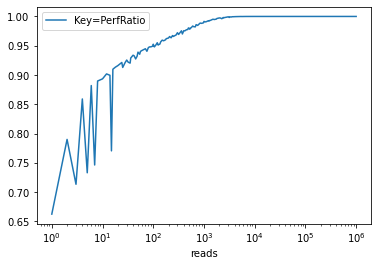

<Figure size 432x288 with 0 Axes>

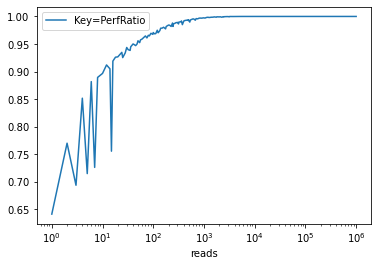

<Figure size 432x288 with 0 Axes>

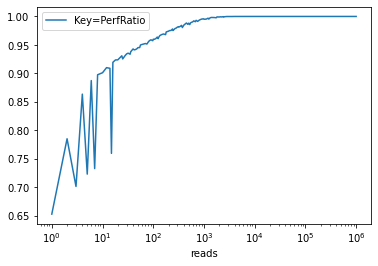

<Figure size 432x288 with 0 Axes>

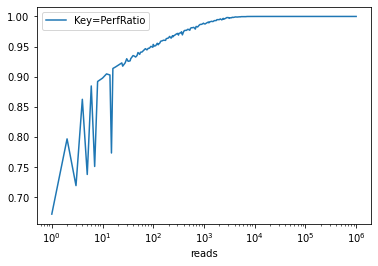

<Figure size 432x288 with 0 Axes>

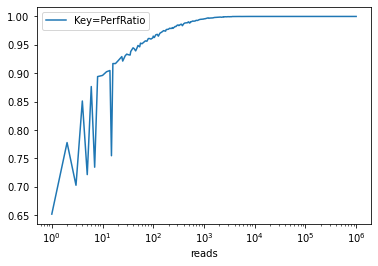

<Figure size 432x288 with 0 Axes>

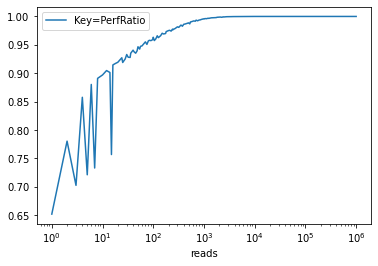

<Figure size 432x288 with 0 Axes>

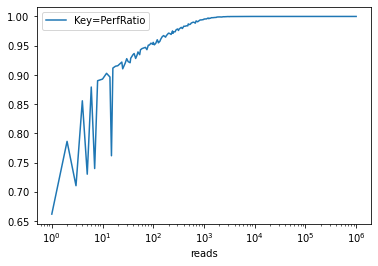

<Figure size 432x288 with 0 Axes>

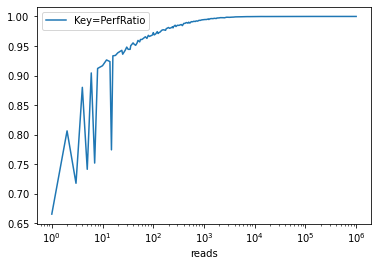

<Figure size 432x288 with 0 Axes>

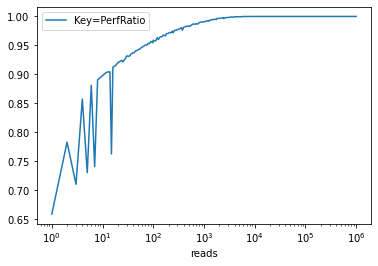

<Figure size 432x288 with 0 Axes>

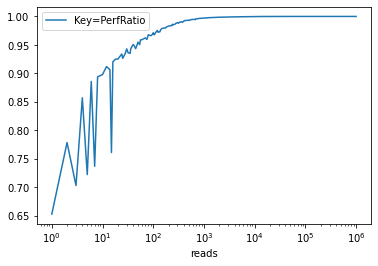

<Figure size 432x288 with 0 Axes>

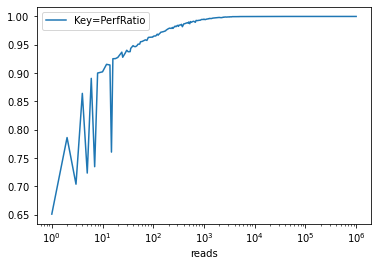

<Figure size 432x288 with 0 Axes>

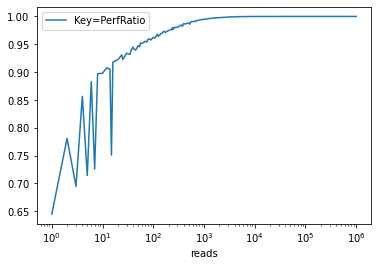

<Figure size 432x288 with 0 Axes>

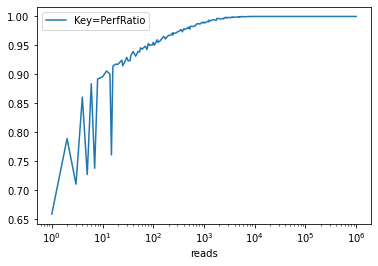

<Figure size 432x288 with 0 Axes>

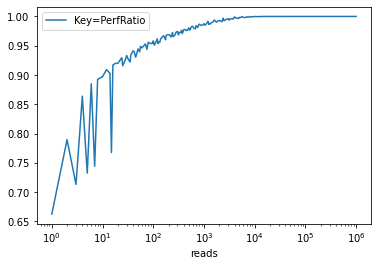

<Figure size 432x288 with 0 Axes>

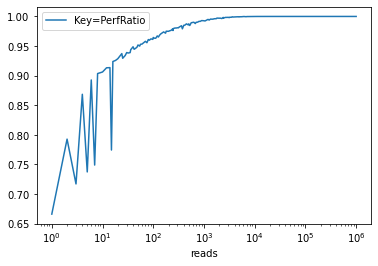

<Figure size 432x288 with 0 Axes>

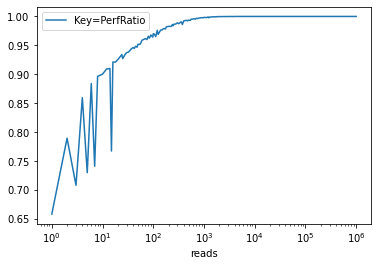

<Figure size 432x288 with 0 Axes>

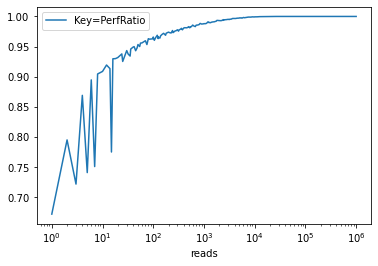

<Figure size 432x288 with 0 Axes>

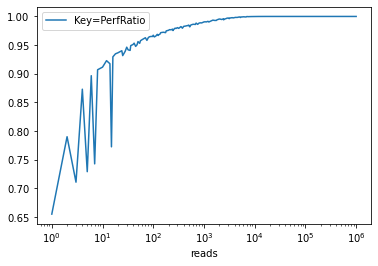

<Figure size 432x288 with 0 Axes>

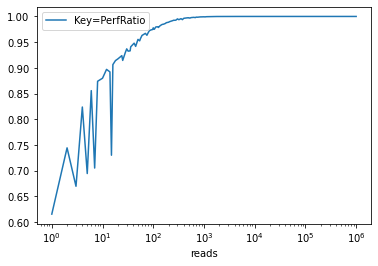

<Figure size 432x288 with 0 Axes>

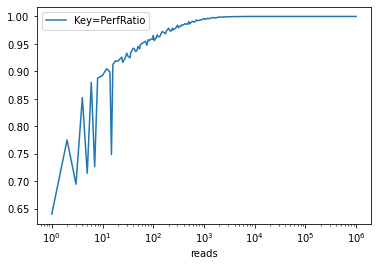

In [44]:
import matplotlib.pyplot as plt
for i in range(20):
    plt.figure()
    vb[vb['instance'] == i].plot(x='reads', y='Key=PerfRatio')
    ax = plt.gca()
    ax.set_xscale('log')

In [49]:
br = training.best_recommended(vb, parameter_names=['sweep', 'Tcfactor', 'Thfactor'],\
                               resource_col='reads')
display(br)

,sweep,Tcfactor,Thfactor
reads,,,
1,1.0,0.0,-2.839286
2,2.0,0.0,-2.351190
3,1.0,0.0,-2.791667
4,4.0,0.0,-1.845238
5,1.0,0.0,-2.827381
...,...,...,...
630000,900.0,0.0,-0.464286
700000,900.0,0.0,-1.059524
800000,800.0,0.0,-0.630952


In [145]:
df_eval_single = df_eval[df_eval['instance'] == 1].copy()
df_eval_single.drop(['sweep_scaled', 'Tcfactor_scaled', 'Thfactor_scaled'], axis=1, inplace=True)

In [153]:
closest = training.evaluate_single(df_eval_single, br, training.scaled_distance,\
                                   parameter_names=['sweep', 'Tcfactor', 'Thfactor'],\
                                   resource_col='reads')

203


In [193]:
all_closest = training.evaluate(df[(df['instance'] == 1) | (df['instance'] == 2)], br.loc[:3, :], training.scaled_distance,\
                                parameter_names=['sweep', 'Tcfactor', 'Thfactor'],\
                                resource_col='reads',\
                               group_on=['instance'])

In [194]:
display(all_closest)

,instance,schedule,sweep,Tcfactor,Thfactor,boots,Key=MinEnergy,ConfInt=lower_Key=MinEnergy,ConfInt=upper_Key=MinEnergy,Key=PerfRatio,...,ConfInt=upper_Key=InvPerfRatio,inst,distance_scaled,sweep_scaled,Tcfactor_scaled,Thfactor_scaled,reads,sweep_rec,Tcfactor_rec,Thfactor_rec
0,1,geometric,1,0.0,-2.875,1,-157.340446,-173.105611,-143.299972,0.641336,...,0.416324,1,0.000080,0.000000,0.0,0.03125,1.0,1.0,0.0,-2.839286
1,1,geometric,1,0.0,-2.875,1,-156.678790,-170.647773,-141.973903,0.638619,...,0.421770,1,0.000080,0.000000,0.0,0.03125,1.0,1.0,0.0,-2.839286
2,1,geometric,1,0.0,-2.875,2,-166.150560,-179.715312,-152.626052,0.677516,...,0.378025,1,0.000080,0.000000,0.0,0.03125,1.0,1.0,0.0,-2.839286
3,1,geometric,1,0.0,-2.875,3,-170.092144,-181.959593,-158.177975,0.693703,...,0.355225,1,0.000080,0.000000,0.0,0.03125,1.0,1.0,0.0,-2.839286
4,1,geometric,1,0.0,-2.875,5,-175.241720,-186.510955,-163.812771,0.714851,...,0.332084,1,0.000080,0.000000,0.0,0.03125,1.0,1.0,0.0,-2.839286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3187,2,geometric,4,0.0,-1.875,200,-229.134363,-231.640693,-227.059559,0.963102,...,0.045583,2,0.000055,0.003003,0.0,0.28125,4.0,4.0,0.0,-1.845238
3188,2,geometric,4,0.0,-1.875,300,-230.003976,-231.640693,-228.243755,0.966741,...,0.040626,2,0.000055,0.003003,0.0,0.28125,4.0,4.0,0.0,-1.845238
3189,2,geometric,4,0.0,-1.875,500,-230.677773,-231.640693,-228.864577,0.969562,...,0.038028,2,0.000055,0.003003,0.0,0.28125,4.0,4.0,0.0,-1.845238
3190,2,geometric,4,0.0,-1.875,700,-231.076897,-231.640693,-229.861279,0.971232,...,0.033856,2,0.000055,0.003003,0.0,0.28125,4.0,4.0,0.0,-1.845238
